## 깊이 추정 모델로 bounding box 깊이 정보 추출

### Marigold 모델로 2D 이미지 깊이 추정하는 과정
+ margigold clone 후 사용 <br/>
https://github.com/prs-eth/marigold

In [1]:
# @title 1.2 👆 Select Checkpoint
# /!pip install ipywidgets==7.7.1 --quiet

from IPython.display import display
import ipywidgets as widgets
import shutil
import torch

ckpt_dic = {
    "Original (higher quality)": "prs-eth/marigold-v1-0",
    "LCM (faster)": "prs-eth/marigold-lcm-v1-0",
}

ckpt_name = 'LCM (faster)'
ckpt_path = ckpt_dic[ckpt_name]
w = widgets.Dropdown(
    options=['Original (higher quality)', 'LCM (faster)'],
    value=ckpt_name,
    description='Checkpoint:',
)


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        ckpt_name = change['new']
        ckpt_path = ckpt_dic[ckpt_name]
        # print(f"Change to checkpoint: {ckpt_name} ({ckpt_path})")

w.observe(on_change)

display(w)
print(f"{ckpt_path = }")

Dropdown(description='Checkpoint:', index=1, options=('Original (higher quality)', 'LCM (faster)'), value='LCM…

ckpt_path = 'prs-eth/marigold-lcm-v1-0'


In [ ]:
import os, glob
from IPython.display import display
import ipywidgets as widgets
import shutil
import torch

# Directories
repo_dir = "/home/aiuser/junoflow/detection/Marigold"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_dir_color = os.path.join(output_dir, "depth_colored")
output_dir_tif = os.path.join(output_dir, "depth_bw")
output_dir_npy = os.path.join(output_dir, "depth_npy")

os.chdir(repo_dir)

In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    "prs-eth/marigold-lcm-v1-0",
    custom_pipeline="marigold_depth_estimation",
    torch_dtype = torch.float16,
    variant = 'fp16'
)

pipe = pipe.to("cuda")

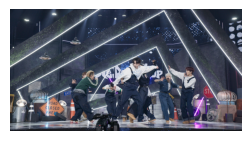

array([[[13, 23, 33],
        [15, 25, 35],
        [24, 31, 41],
        ...,
        [27, 37, 49],
        [26, 36, 48],
        [29, 39, 51]],

       [[10, 24, 33],
        [13, 26, 35],
        [22, 30, 41],
        ...,
        [29, 39, 51],
        [28, 38, 50],
        [29, 39, 51]],

       [[ 7, 25, 35],
        [11, 25, 34],
        [17, 27, 37],
        ...,
        [32, 42, 54],
        [30, 40, 52],
        [31, 41, 53]],

       ...,

       [[43, 48, 54],
        [25, 24, 30],
        [19, 14, 20],
        ...,
        [20, 18, 23],
        [ 9,  8, 13],
        [15, 19, 22]],

       [[23, 30, 36],
        [31, 31, 39],
        [26, 19, 26],
        ...,
        [22, 21, 26],
        [34, 35, 39],
        [12, 16, 19]],

       [[ 9, 18, 25],
        [19, 19, 27],
        [19, 14, 21],
        ...,
        [44, 44, 46],
        [33, 34, 36],
        [16, 22, 22]]], dtype=uint8)

In [4]:
from glob import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Pre-defined function
def display_images(image_paths, n_images_per_row = 4):
    n_rows = math.ceil(len(image_paths) / n_images_per_row)

    plt.figure(figsize=(10, 2 * n_rows))  # Adjust the size as needed
    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        plt.subplot(n_rows, n_images_per_row, i + 1)  # Number of rows, number of images per row, current index
        plt.imshow(img)
        plt.axis('off')  # To not display axis

    plt.tight_layout()
    plt.show()
    return img


image_paths = glob(os.path.join(input_dir, '240308_5_6570.jpg'))

display_images(image_paths)

In [ ]:
denoising_steps = 4 # @param {type:"integer"}
ensemble_size = 5 # @param {type:"integer"}
processing_res = 768 # @param {type:"integer"}
match_input_res = True # @param ["False", "True"]

import logging
import numpy as np
import torch
from tqdm.auto import tqdm
from glob import glob
from PIL import Image

EXTENSION_LIST = [".jpg", ".jpeg", ".png"]

# Image list
rgb_filename_list = glob(os.path.join(input_dir, '240308_5_6570.jpg'))
rgb_filename_list = [
    f for f in rgb_filename_list if os.path.splitext(f)[1].lower() in EXTENSION_LIST
]
rgb_filename_list = sorted(rgb_filename_list)

# Create output folders
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_color, exist_ok=True)
os.makedirs(output_dir_tif, exist_ok=True)
os.makedirs(output_dir_npy, exist_ok=True)

# Run Inference
with torch.no_grad():
    os.makedirs(output_dir, exist_ok=True)

    for rgb_path in tqdm(rgb_filename_list, desc=f"Estimating depth", leave=True):
        # Read input image
        input_image = Image.open(rgb_path)

        # Predict depth
        pipeline_output = pipe(
            input_image,
            denoising_steps=denoising_steps,     # optional
            ensemble_size=ensemble_size,       # optional
            processing_res=processing_res,     # optional
            match_input_res=match_input_res,   # optional
            batch_size=0,           # optional
            color_map="Spectral",   # optional
            show_progress_bar=True, # optional
            # seed=2024,              # optional
        )

        depth_pred: np.ndarray = pipeline_output.depth_np
        depth_colored: Image.Image = pipeline_output.depth_colored

        # Save as npy
        rgb_name_base = os.path.splitext(os.path.basename(rgb_path))[0]
        pred_name_base = rgb_name_base + "_pred"
        npy_save_path = os.path.join(output_dir_npy, f"{pred_name_base}.npy")
        if os.path.exists(npy_save_path):
            logging.warning(f"Existing file: '{npy_save_path}' will be overwritten")
        np.save(npy_save_path, depth_pred)

        # Save as 16-bit uint png
        depth_to_save = (depth_pred * 65535.0).astype(np.uint16)
        png_save_path = os.path.join(output_dir_tif, f"{pred_name_base}.png")
        if os.path.exists(png_save_path):
            logging.warning(f"Existing file: '{png_save_path}' will be overwritten")
        Image.fromarray(depth_to_save).save(png_save_path, mode="I;16")

        # Colorize
        colored_save_path = os.path.join(
            output_dir_color, f"{pred_name_base}_colored.png"
        )
        if os.path.exists(colored_save_path):
            logging.warning(f"Existing file: '{colored_save_path}' will be overwritten")
        depth_colored.save(colored_save_path)

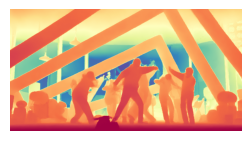

In [5]:
output_images_colored  = glob(os.path.join(output_dir_color, "240308_5_6570_pred_colored.png"))
temp = display_images(output_images_colored)

### bounding box 별 깊이 정보 비교 후 가장 앞 박스 추출

In [6]:
def iou(box1, box2):
    """두 바운딩 박스의 Intersection over Union (IoU) 값을 계산합니다."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area_box1 + area_box2 - intersection

    return intersection / union if union > 0 else 0

주어진 데이터셋의 bounding box
+ 겹치는 box들은 직캠으로써 bounding box 역할 수행을 하지 못함
+ 가장 앞의 box를 추출하는 과정이 필요

['0 민재 0.6764340400695801 0.6923799161557798 0.15897417068481445 0.5412239639847367',
 '0 세은 0.30501333624124527 0.6886086357964409 0.1605192869901657 0.5464548746744792',
 '0 수민 0.3290591388940811 0.6661437846996167 0.1685483157634735 0.5736938759132668',
 '0 예찬 0.4885708838701248 0.7090936872694228 0.13975676894187927 0.47561054936161745',
 '0 유준 0.5743258595466614 0.7174621016890914 0.13792216777801514 0.46966111924913195',
 '0 준민 0.7516038119792938 0.6687677454065394 0.16746073961257935 0.5698877405237268',
 '0 진식 0.5680076777935028 0.6654267205132378 0.16528302431106567 0.5626996640805845',
 '0 헌터 0.5330567955970764 0.6553219830548321 0.18595242500305176 0.6330314353660301',
 '0 현우 0.44285207986831665 0.7077401337800202 0.13961756229400635 0.47515603524667244']

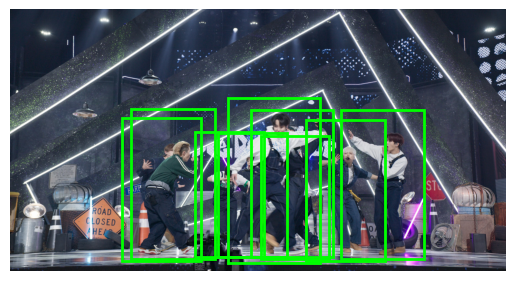

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
img_pth = './input/240308_5_6570.jpg'
img = plt.imread(img_pth)

lines = []
with open('./input/240308_5_6570.txt', 'r', encoding='cp949') as file:
    for line in file:
        lines.append(line.strip())

plt.imshow(img, 'gray')
for i in range(len(lines)):
    width = float(lines[i].split(' ')[4])*2048
    height = float(lines[i].split(' ')[5])*1080
    start_x = float(lines[i].split(' ')[2])*2048 - float(lines[i].split(' ')[4])*2048*0.5
    start_y = float(lines[i].split(' ')[3])*1080 - float(lines[i].split(' ')[5])*1080*0.5
    width, height, start_x, start_y = int(width), int(height), int(start_x), int(start_y)

    rect = patches.Rectangle((start_x, start_y), width, height, linewidth = 2, edgecolor = 'lime', facecolor = 'none')

    ax.add_patch(rect)
plt.axis('off')
    
lines

겹치는 박스는 marigold에 통과시켜 가장 앞에 있는 박스만 추출

In [27]:
import os
import cv2
from ultralytics import YOLO
import shutil
from PIL import Image
from tqdm import tqdm

denoising_steps = 4
ensemble_size = 5
processing_res = 768
match_input_res = True

model = YOLO('/home/aiuser/junoflow/detection/yolov8m.pt')
while True:
    new_lines = []
    all_rois = []
    result = []
    
    for line_idx, line in enumerate(tqdm(lines)):
        parts = line.strip().split()
        x_center, y_center, width, height = map(float, parts[2:])

        x_center, y_center, width, height = x_center * img.shape[1], y_center * img.shape[0], width * \
                                            img.shape[1], height * img.shape[0]
        x1, y1, x2, y2 = int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(
            y_center + height / 2)

        # ROI의 크기가 0보다 큰 경우에만 처리
        roi = img[y1:y2, x1:x2]
        if roi.size > 0 and roi.shape[0] > 0 and roi.shape[1] > 0:
            results = model.predict(roi, conf=0.5, classes=[0], verbose=False)  # 클래스 0 ('person')에 대해서만 탐지
            # (1번 필터) : Person이 탐지되지않는 경우 필터링
            if results[0].boxes.xyxy.size(0) == 0:  # 'person' 탐지되지 않은 경우
                continue  # 이 ROI는 겹침 검사에서 제외
            result.append(results)

            all_rois.append((line_idx, (x1, y1, x2, y2), line))
 
    for idx1, (roi1_idx, roi1, line1) in enumerate(all_rois):
        overlap = False
        for idx2, (roi2_idx, roi2, line2) in enumerate(all_rois):
            if idx1 >= idx2:
                continue
            # print(roi1_idx, roi1, roi2_idx, roi2)
            
            # (2번 필터) : 두 ROI가 threshold 이상 겹치면 필터링
            threshold = 0.60    # 0.60% 이상 겹침
            if iou(roi1, roi2) > threshold:
                # print(idx1, roi1, idx2, roi2)
            
                # roi1 
                roi_img1 = img[roi1[1]:roi1[3], roi1[0]:roi1[2]] # 앞 roi로 이미지 자르기
                bx1 = result[idx1][0].boxes.xyxy.cpu() # 박스 안의 사람으로 판단되는 객체들의 좌표
                mid_x1 = (bx1[:, 0] + bx1[:, 2]) / 2 # 박스의 x 중간 자표

                img_center1 = result[idx1][0].orig_shape[1] / 2 # roi1의 좌표 너비의 중간 x좌표
                center_bx1 = torch.argmin(torch.abs(mid_x1 - img_center1)) # 중간에 가까운 객체가 박스 주인공 객체
                # print(center_bx1)
                
                r_img1 = roi_img1[int(bx1[center_bx1][1]):int(bx1[center_bx1][3]), int(bx1[center_bx1][0]):int(bx1[center_bx1][2])]
                
                # roi2
                roi_img2 = img[roi2[1]:roi2[3], roi2[0]:roi2[2]]
                
                bx2 = result[idx2][0].boxes.xyxy.cpu()
                mid_x2 = (bx2[:, 0] + bx2[:, 2]) / 2

                img_center2 = result[idx2][0].orig_shape[1] / 2
                center_bx2 = torch.argmin(torch.abs(mid_x2 - img_center2))
                # print(center_bx2)
                
                r_img2 = roi_img2[int(bx2[center_bx2][1]):int(bx2[center_bx2][3]), int(bx2[center_bx2][0]):int(bx2[center_bx2][2])]
                
                # 첫 번째 roi에 대한 깊이 정보 추출
                pipeline_output1 = pipe(
                    Image.fromarray(roi_img1),
                    denoising_steps=denoising_steps,     
                    ensemble_size=ensemble_size,      
                    processing_res=processing_res,     
                    match_input_res=match_input_res, 
                    batch_size=0,          
                    color_map="Spectral",  
                    show_progress_bar=False 
                    )

                # 두 번째 roi에 대한 깊이 정보 추출
                pipeline_output2 = pipe(
                    Image.fromarray(roi_img2),
                    denoising_steps=denoising_steps,   
                    ensemble_size=ensemble_size,      
                    processing_res=processing_res,   
                    match_input_res=match_input_res,  
                    batch_size=0,          
                    color_map="Spectral",  
                    show_progress_bar=False 
                    )        
                
                # 두 roi의 픽셀 비교
                # 각 ROI에서 픽셀의 평균값이 작은 객체가 앞에 있는 것
                # if np.mean(pipeline_output1.depth_colored) < np.mean(pipeline_output2.depth_colored):
                if pipeline_output1.depth_np.mean() < pipeline_output2.depth_np.mean():     
                    overlap = True
                    break
            
        if not overlap:
            new_lines.append(line1)
    
    if len(lines) == len(new_lines):
        break
    else: lines = new_lines
    
new_lines

100%|██████████| 6/6 [00:00<00:00, 15.07it/s]


['0 민재 0.6764340400695801 0.6923799161557798 0.15897417068481445 0.5412239639847367',
 '0 수민 0.3290591388940811 0.6661437846996167 0.1685483157634735 0.5736938759132668',
 '0 준민 0.7516038119792938 0.6687677454065394 0.16746073961257935 0.5698877405237268',
 '0 진식 0.5680076777935028 0.6654267205132378 0.16528302431106567 0.5626996640805845',
 '0 헌터 0.5330567955970764 0.6553219830548321 0.18595242500305176 0.6330314353660301',
 '0 현우 0.44285207986831665 0.7077401337800202 0.13961756229400635 0.47515603524667244']

marigold를 이용해 정제한 바운딩 박스

(-0.5, 2047.5, 1079.5, -0.5)

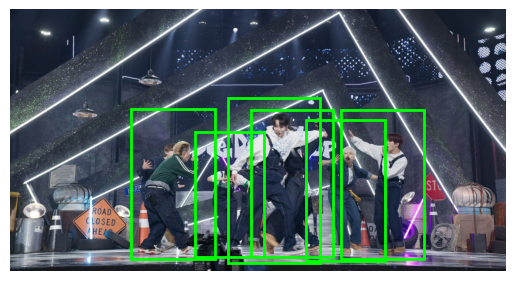

In [28]:
fig, ax = plt.subplots()
plt.imshow(img)
for i in range(len(new_lines)):
    width = float(new_lines[i].split(' ')[4])*2048
    height = float(new_lines[i].split(' ')[5])*1080
    start_x = float(new_lines[i].split(' ')[2])*2048 - float(new_lines[i].split(' ')[4])*2048*0.5
    start_y = float(new_lines[i].split(' ')[3])*1080 - float(new_lines[i].split(' ')[5])*1080*0.5
    width, height, start_x, start_y = int(width), int(height), int(start_x), int(start_y)

    rect = patches.Rectangle((start_x, start_y), width, height, linewidth = 2, edgecolor = 'lime', facecolor = 'none')

    ax.add_patch(rect)
    
plt.axis('off')

기존의 사용하던 방식

In [15]:
import os
import cv2
from ultralytics import YOLO
import shutil
from PIL import Image
from tqdm import tqdm

denoising_steps = 4
ensemble_size = 5
processing_res = 768
match_input_res = True

new_lines = []
all_rois = []
result = []

model = YOLO('/home/aiuser/junoflow/detection/yolov8m.pt')
for line_idx, line in enumerate(tqdm(lines)):
    parts = line.strip().split()
    x_center, y_center, width, height = map(float, parts[2:])

    x_center, y_center, width, height = x_center * img.shape[1], y_center * img.shape[0], width * \
                                        img.shape[1], height * img.shape[0]
    x1, y1, x2, y2 = int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(
        y_center + height / 2)

    # ROI의 크기가 0보다 큰 경우에만 처리
    roi = img[y1:y2, x1:x2]
    if roi.size > 0 and roi.shape[0] > 0 and roi.shape[1] > 0:
        results = model.predict(roi, conf=0.5, classes=[0], verbose=False)  # 클래스 0 ('person')에 대해서만 탐지
        # (1번 필터) : Person이 탐지되지않는 경우 필터링
        if results[0].boxes.xyxy.size(0) == 0:  # 'person' 탐지되지 않은 경우
            continue  # 이 ROI는 겹침 검사에서 제외
        result.append(results)

        all_rois.append((line_idx, (x1, y1, x2, y2), line))

for idx1, (roi1_idx, roi1, line1) in enumerate(all_rois):
    overlap = False
    for idx2, (roi2_idx, roi2, _) in enumerate(all_rois):
        if idx1 == idx2:
            continue 

        # (2번 필터) : 두 ROI가 threshold 이상 겹치면 필터링
        threshold = 0.60 # 75% 이상 겹침
        if iou(roi1, roi2) > threshold:
            overlap = True
            break
    
    if not overlap:
        new_lines.append(line1)

new_lines

100%|██████████| 9/9 [00:00<00:00, 21.22it/s]


['0 민재 0.6764340400695801 0.6923799161557798 0.15897417068481445 0.5412239639847367',
 '0 예찬 0.4885708838701248 0.7090936872694228 0.13975676894187927 0.47561054936161745',
 '0 준민 0.7516038119792938 0.6687677454065394 0.16746073961257935 0.5698877405237268',
 '0 현우 0.44285207986831665 0.7077401337800202 0.13961756229400635 0.47515603524667244']

(-0.5, 2047.5, 1079.5, -0.5)

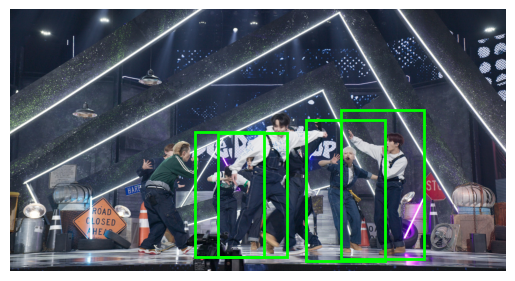

In [16]:
fig, ax = plt.subplots()
plt.imshow(img)
for i in range(len(new_lines)):
    width = float(new_lines[i].split(' ')[4])*2048
    height = float(new_lines[i].split(' ')[5])*1080
    start_x = float(new_lines[i].split(' ')[2])*2048 - float(new_lines[i].split(' ')[4])*2048*0.5
    start_y = float(new_lines[i].split(' ')[3])*1080 - float(new_lines[i].split(' ')[5])*1080*0.5
    width, height, start_x, start_y = int(width), int(height), int(start_x), int(start_y)

    rect = patches.Rectangle((start_x, start_y), width, height, linewidth = 2, edgecolor = 'lime', facecolor = 'none')

    ax.add_patch(rect)
    
plt.axis('off')

바운딩 박스를 roi 추출하여 marigold에 통과시켰을 때 나오는 depth map

In [10]:
lines = ['0 세은 0.30501333624124527 0.6886086357964409 0.1605192869901657 0.5464548746744792',
         '0 수민 0.3290591388940811 0.6661437846996167 0.1685483157634735 0.5736938759132668',]

import os
import cv2
from ultralytics import YOLO
import shutil
from PIL import Image
from tqdm import tqdm

denoising_steps = 4
ensemble_size = 5
processing_res = 768
match_input_res = True

model = YOLO('/home/aiuser/junoflow/detection/yolov8m.pt')
while True:
    new_lines = []
    all_rois = []
    result = []
    
    for line_idx, line in enumerate(tqdm(lines)):
        parts = line.strip().split()
        x_center, y_center, width, height = map(float, parts[2:])

        x_center, y_center, width, height = x_center * img.shape[1], y_center * img.shape[0], width * \
                                            img.shape[1], height * img.shape[0]
        x1, y1, x2, y2 = int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(
            y_center + height / 2)

        # ROI의 크기가 0보다 큰 경우에만 처리
        roi = img[y1:y2, x1:x2]
        if roi.size > 0 and roi.shape[0] > 0 and roi.shape[1] > 0:
            results = model.predict(roi, conf=0.5, classes=[0], verbose=False)  # 클래스 0 ('person')에 대해서만 탐지
            # (1번 필터) : Person이 탐지되지않는 경우 필터링
            if results[0].boxes.xyxy.size(0) == 0:  # 'person' 탐지되지 않은 경우
                continue  # 이 ROI는 겹침 검사에서 제외
            result.append(results)

            all_rois.append((line_idx, (x1, y1, x2, y2), line))
 
    for idx1, (roi1_idx, roi1, line1) in enumerate(all_rois):
        overlap = False
        for idx2, (roi2_idx, roi2, line2) in enumerate(all_rois):
            if idx1 >= idx2:
                continue
            # print(roi1_idx, roi1, roi2_idx, roi2)
            
            # (2번 필터) : 두 ROI가 threshold 이상 겹치면 필터링
            threshold = 0.65    # 70% 이상 겹침
            if iou(roi1, roi2) > threshold:
                # print(idx1, roi1, idx2, roi2)
            
                # roi1 
                roi_img1 = img[roi1[1]:roi1[3], roi1[0]:roi1[2]] # 앞 roi로 이미지 자르기
                bx1 = result[idx1][0].boxes.xyxy.cpu() # 박스 안의 사람으로 판단되는 객체들의 좌표
                mid_x1 = (bx1[:, 0] + bx1[:, 2]) / 2 # 박스의 x 중간 자표

                img_center1 = result[idx1][0].orig_shape[1] / 2 # roi1의 좌표 너비의 중간 x좌표
                center_bx1 = torch.argmin(torch.abs(mid_x1 - img_center1)) # 중간에 가까운 객체가 박스 주인공 객체
                # print(center_bx1)
                
                r_img1 = roi_img1[int(bx1[center_bx1][1]):int(bx1[center_bx1][3]), int(bx1[center_bx1][0]):int(bx1[center_bx1][2])]
                
                # roi2
                roi_img2 = img[roi2[1]:roi2[3], roi2[0]:roi2[2]]
                
                bx2 = result[idx2][0].boxes.xyxy.cpu()
                mid_x2 = (bx2[:, 0] + bx2[:, 2]) / 2

                img_center2 = result[idx2][0].orig_shape[1] / 2
                center_bx2 = torch.argmin(torch.abs(mid_x2 - img_center2))
                # print(center_bx2)
                
                r_img2 = roi_img2[int(bx2[center_bx2][1]):int(bx2[center_bx2][3]), int(bx2[center_bx2][0]):int(bx2[center_bx2][2])]
                
                pipeline_output1 = pipe(
                    Image.fromarray(roi_img1),
                    denoising_steps=denoising_steps,     # optional
                    ensemble_size=ensemble_size,       # optional
                    processing_res=processing_res,     # optional
                    match_input_res=match_input_res,   # optional
                    batch_size=0,           # optional
                    color_map="Spectral",   # optional
                    show_progress_bar=False # optional
                    )

                pipeline_output2 = pipe(
                    Image.fromarray(roi_img2),
                    denoising_steps=denoising_steps,     # optional
                    ensemble_size=ensemble_size,       # optional
                    processing_res=processing_res,     # optional
                    match_input_res=match_input_res,   # optional
                    batch_size=0,           # optional
                    color_map="Spectral",   # optional
                    show_progress_bar=False # optional
                    )        
                
                # # 각 ROI에서 픽셀의 평균값이 작은 객체가 앞에 있는 것
                # if np.mean(pipeline_output1.depth_colored) < np.mean(pipeline_output2.depth_colored):
                if pipeline_output1.depth_np.mean() < pipeline_output2.depth_np.mean():     
                    overlap = True
                    break
            
        if not overlap:
            new_lines.append(line1)
    
    if len(lines) == len(new_lines):
        break
    else: lines = new_lines
    
new_lines

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 63.69it/s]


['0 수민 0.3290591388940811 0.6661437846996167 0.1685483157634735 0.5736938759132668']

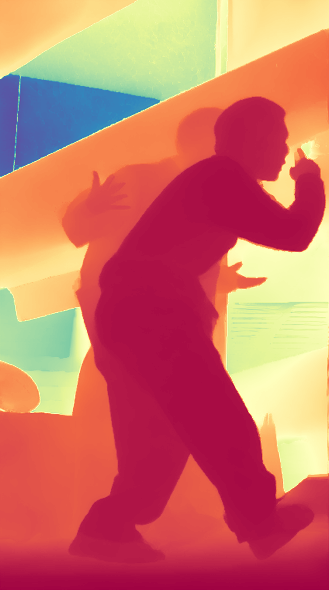

In [20]:
pipeline_output1.depth_colored

In [19]:
np.mean(pipeline_output1.depth_np)

0.2689686

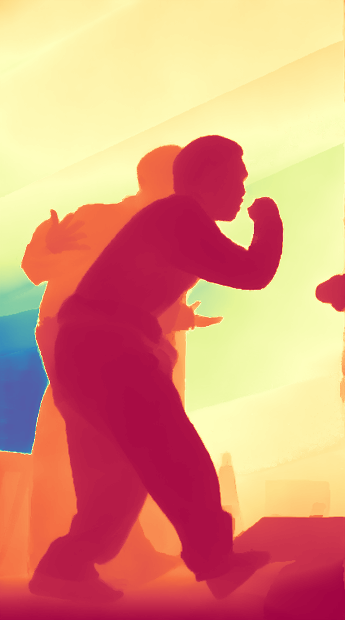

In [16]:
pipeline_output2.depth_colored

In [21]:
np.mean(pipeline_output2.depth_np)

0.31226084